In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

from scripts.processing import clean_data, pre_process_data
from scripts.pipeline import create_preprocessing_pipeline

# Model development

## Loading data

Split tabular data into train and test. Loading train below.

In [ ]:
raw_train_data = pd.read_csv('data/train.csv') 

## Data cleaning

- Removing columns with no information. e.g. 'Loss_code', 'Loss_description' etc. ('Vehicle_registration_present' too as over 99% was 'Yes')
- Dropped rows with some negative values e.g. negative claim costs and notification periods.
- Converting string values such as 'n/k', 'n/a' to Python None's for missing value analysis later on.

In [ ]:
train_data = clean_data(raw_train_data)

## Data pre-processing

The following gives an overview of further pre-processing after exploring the data. Some examples shown below but I used exploration.ipynb for this.

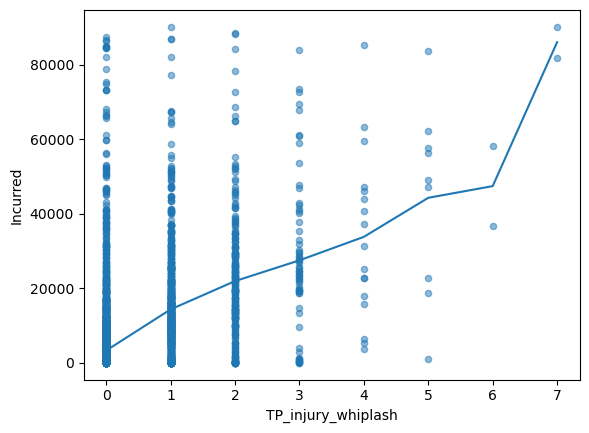
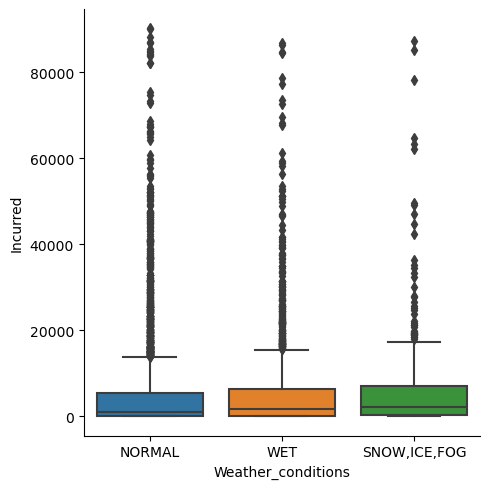
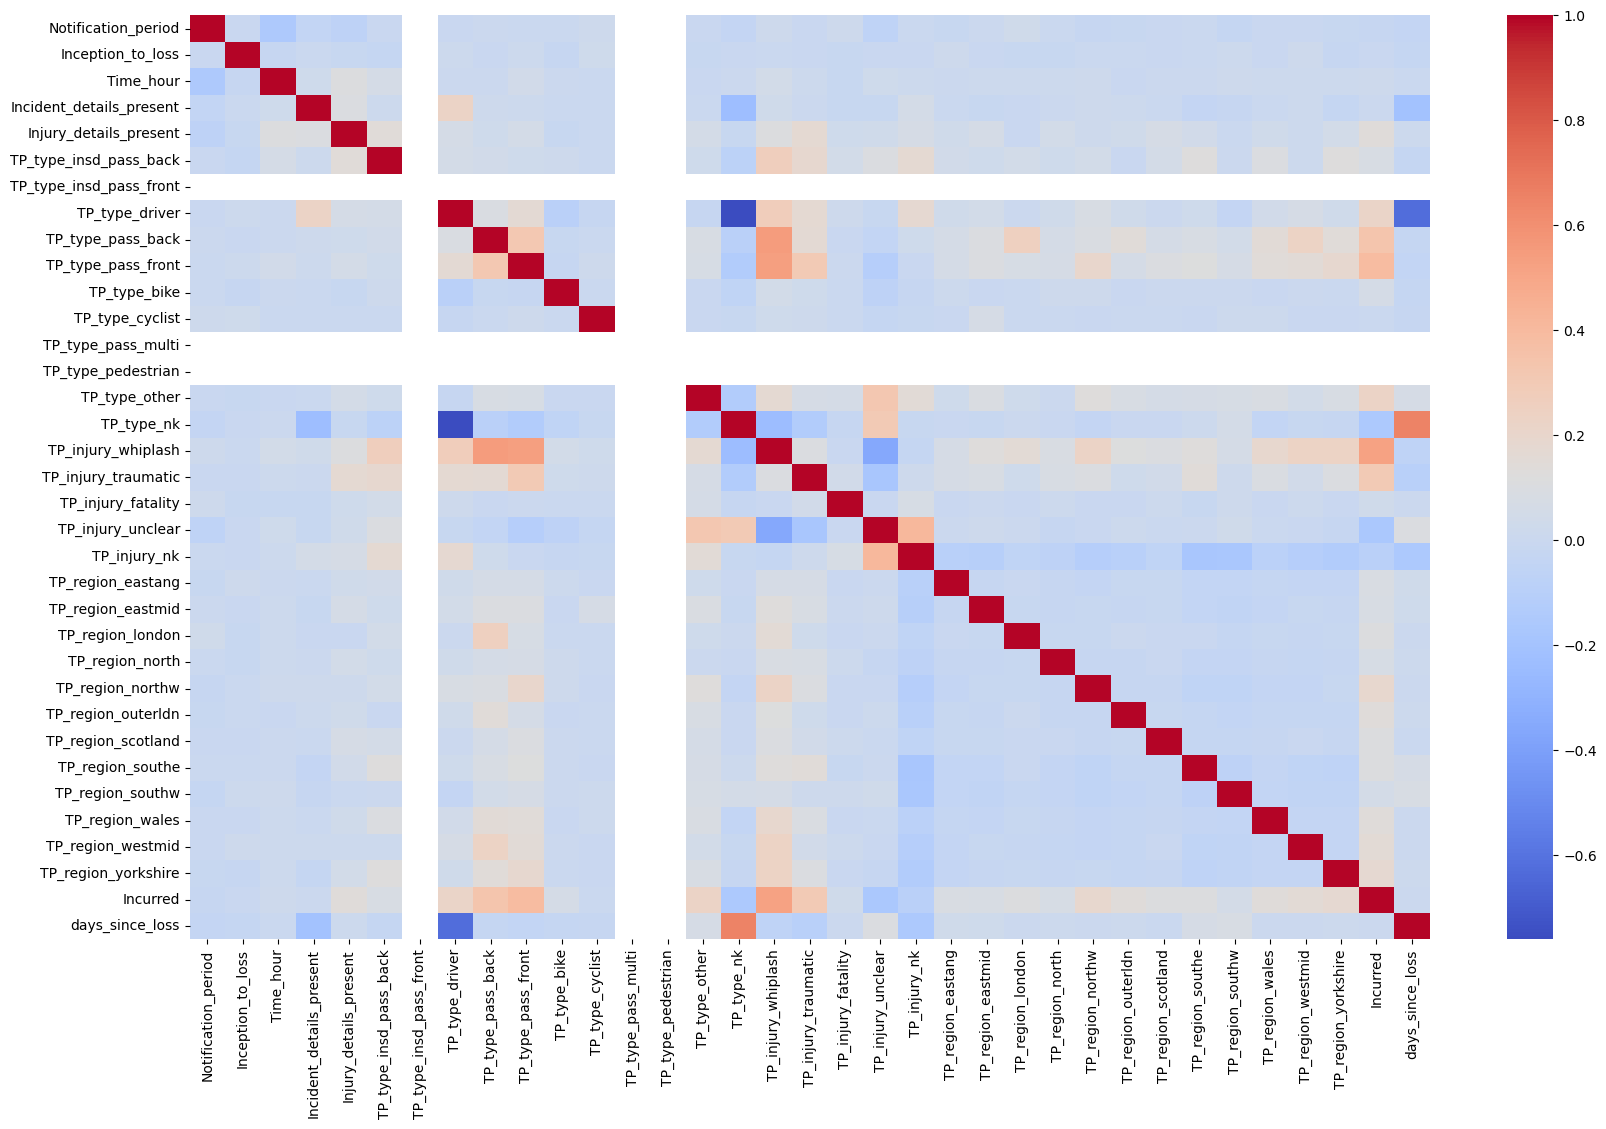

Some steps taken as a result:
- Dropping columns with too many missing values and filling in others.
- Creation of new features. e.g. TP_severe_injuries from TP_injury columns. Converting Time_hour to binary feature determining whether it occurred during the night as I saw the average claim was slightly higher during this period and constant otherwise.
- Removing very large Incurred outliers. From inspection, the reason for such large claim amounts is not clear (other rows have similar characteristics at much lower claim amounts). Perhaps very expensive cars were involved in the largest of claims. Just a guess, but for now they wont be considered.



In [ ]:
train_data = pre_process_data(train_data)

## Passing data through sklearn pipeline

- One hot encoding, scaling, imputing etc.

In [ ]:
# Columns to scale
num_cols = train_data.select_dtypes(include=['float64', 'int64']).columns.drop('Incurred')
# Columns to one hot encode
ohe_cols = ['Notifier', 'Location_of_incident', 'Weather_conditions']

pipeline = create_preprocessing_pipeline(num_cols, ohe_cols)

X = train_data.drop(columns=['Incurred'])
y = train_data['Incurred']

X_preprocessed = pipeline.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

## Getting RMSE for various models

Example shown below.

![Screenshot 2024-06-12 at 23.03.32.png](<attachment:Screenshot 2024-06-12 at 23.03.32.png>)
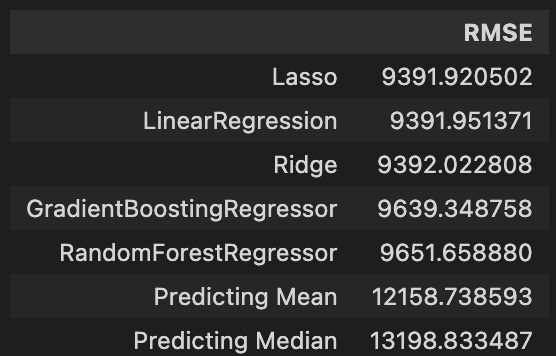

In [ ]:
models = [LinearRegression(), Ridge(), Lasso(), RandomForestRegressor(), GradientBoostingRegressor()]

results = {}

for model in models:

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[model.__class__.__name__] = root_mean_squared_error(y_test, y_pred)

results['Predicting Mean'] = root_mean_squared_error(y_test, [y_train.mean()]*len(y_test))
results['Predicting Median'] = root_mean_squared_error(y_test, [y_train.median()]*len(y_test))

pd.DataFrame.from_dict(results, orient='index', columns=['RMSE']).sort_values(by='RMSE')

## Testing various values of L1 regularisation strength for Lasso

In [ ]:

from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 1, 10, 100]}

lasso = Lasso()
lasso_gs = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
lasso_gs.fit(X_train, y_train)
best_lasso = lasso_gs.best_estimator_
y_pred = best_lasso.predict(X_test)
root_mean_squared_error(y_test, y_pred)

## Improving the model

Incurred values are incredibly skewed with a large presence of zero values. The current model does not predict these smaller values well. Perhaps an initial model could be used to classify whether a claim will large, and then if so use a secondary model similar to this notebook. Either way would need to ask sme about these zero values and why they're there

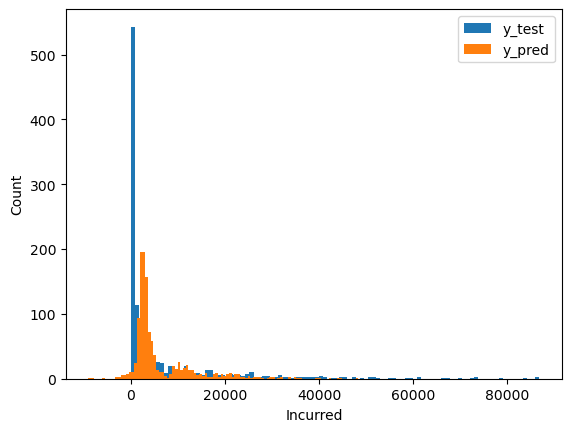


In [ ]:
# Plot y_test histogram vs y pred histogram
plt.hist(y_test, bins=100, label='y_test')
plt.hist(y_pred, bins=100, label='y_pred')
plt.xlabel('Incurred')
plt.ylabel('Count')
plt.legend()


In [ ]:
feature_names = X_preprocessed.columns
coefficients = best_lasso.coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=np.where(coef_df['Coefficient'] > 0, 'green', 'red'))

# Add labels and title
plt.ylabel('Feature')
plt.xlabel('Coefficient')
plt.title('Feature Importance in Lasso Regression')
plt.tight_layout()